This code generates several scenarios that may be encountered in real life.

0. All nodes honest

1. One node misreports its coordinates while reporting (self-contradictory) accurate distances
2. One node misreports its coordinates while reporting false distances that match the false coordinates
3. One node misreports its distances to peers while reporting accurate coordinates
4. One node claims to be in a location it is not, and no other nodes can see it. It does not provide fake distances to its "neighbors".
5. One node claims to be in a location it is not, and no other nodes can see it. It provides fake distances to it's "neighbors".
6. A group of nodes claim to be in a location they are not, and no other nodes can see them. They do not provide fake distances to their "neighbors".
7. A group of nodes claim to be in a location they are not, and no other nodes can see them. They provide fake distances to their "neighbors".
8. Two nodes collude- one node is totally honest, except for the fact that it confirms dishonest metrics from another.
9. A group of nodes do the above
10. One node misreports its coordinates, misreports its own measurements to other nodes, and manipulates its responses to other nodes by delaying them and looking like it is further away from them than it really is

Output: 
- A $n \times n$ distances matrix $D$ where $D_{ij}$ is $i$'s  measurement of $j$, and vice versa.
- A $n \times 2$ coordinates matrix $C$ where $C_i$ is $[ x, y ]$ for node $i$

This data will contain the falsehoods injected by the dishonest nodes. In real life this data will be collected as submissions of peer measurements and coordinates from each node, but since they will probably be analyzed in this format, we will skip the round trip into the wire format.

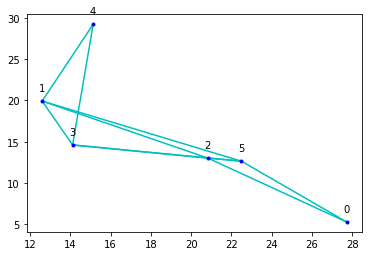

In [49]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180

FIELD_SIZE = 30
NUM_NODES = 6
MAX_DISTANCE = 15

def generate_points():
#     xy = np.random.normal(0.5, 0.25, size=(2, numNodes)) * fieldSize
    xy = np.random.uniform(size=(2, NUM_NODES)) * FIELD_SIZE
    points = np.column_stack(xy)
    return points

def plot_points(points):
    # Put data in format preffered by plot
    xy = np.array([points[0:, 0], points[0:, 1]])
    
    # plot connections
    kdTree = spatial.cKDTree(points)
    pairs = list(kdTree.query_pairs(MAX_DISTANCE))

    def connectpoints(x,y,p1,p2):
        x1, x2 = x[p1], x[p2]
        y1, y2 = y[p1], y[p2]
        plt.plot([x1,x2],[y1,y2],'c-')

    for i in pairs:
        connectpoints(xy[0], xy[1], i[0], i[1])
    
    # plot points
    plt.plot(xy[0], xy[1], 'b.')
    
    # plot labels
    label = 0
    for x, y in zip(xy[0], xy[1]):
        plt.annotate(label, # this is the text
                     (x, y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        label = label + 1

def make_dist_matrix(points, randomize=False):
    kdTree = spatial.cKDTree(points)
    dists = kdTree.sparse_distance_matrix(kdTree, MAX_DISTANCE)
    dists = dists.toarray()
    
    # Randomize distances matrix (or not)
    if randomize: 
        dists = dists * np.random.normal(1, 0.1, dists.shape)
        
    return dists

def make_honest():
    C = generate_points()
    D = make_dist_matrix(C)
    plot_points(C)
    
    return (C, D)

honest = make_honest()

plt.show()

dishonest index: 1
honest coordinates: [12.59452304 19.90920901]
dishonest coordinates: [15.27350655 22.96664789]


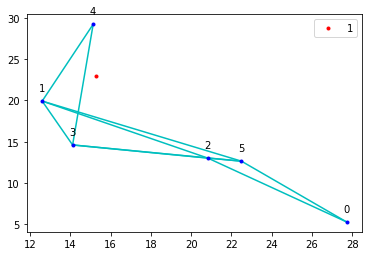

In [106]:
# 1. One node misreports its coordinates while reporting (self-contradictory) accurate distances
def make_dishonest1(C, D, minpeer=3, dishonesty=0.1):
    _C = np.copy(C)
    _D = np.copy(D)
    
    # Choose random node with more than minpeer peers
    nz = np.count_nonzero(_D, axis=1)
    nz = np.where(nz >= minpeer)[0]
    i = nz[np.random.randint(0, nz.size)]
    
    # Offset node by random offsets scaled to field size and desired amount of dishonesty
    xrand = FIELD_SIZE * np.random.normal(0, dishonesty)
    yrand = FIELD_SIZE * np.random.normal(0, dishonesty)
    _C[i] = np.array([_C[i][0] + xrand, _C[i][1] + yrand])
    
    print("dishonest index:", i)
    print("honest coordinates:", C[i])
    print("dishonest coordinates:", _C[i])
    
    plot_points(C)
    plt.plot(_C[i][0], _C[i][1], 'r.', label=i)
    plt.legend()
    plt.show()

    return (_C, _D, i)

dishonest1 = make_dishonest1(*honest)

plt.show()


dishonest index: 1
honest coordinates: [12.59452304 19.90920901]
dishonest coordinates: [14.01711793 23.60340291]


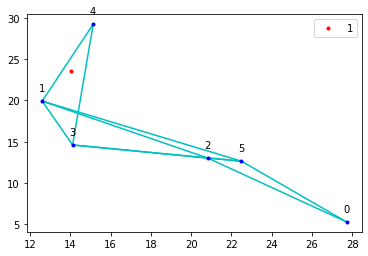

honest distances: [ 0.          0.         10.75282678  5.53156335  9.65967021 12.29316531]
dishonest distances: [ 0.          0.         12.60887807  9.01554145  5.73586177 13.87380509]


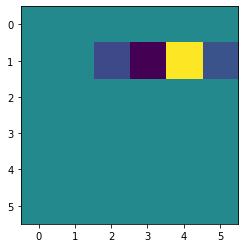

In [92]:
# 2. One node misreports its coordinates while reporting false distances that match the false coordinates
def make_dishonest2(C, D, minpeer=3, dishonesty=0.1):
    (_C, _D, i) = make_dishonest1(C, D, minpeer, dishonesty)
    
    # Generate distances for dishonest node with fake coordinates
    _D[i] = make_dist_matrix(_C)[i]
    
    print("honest distances:", D[i])
    print("dishonest distances:", _D[i])
    
    plt.imshow(D - _D)
    plt.show()
    
    return (_C, _D, i)

dishonest2 = make_dishonest2(*honest)

dishonest coordinates [13.87325657 20.03389021]


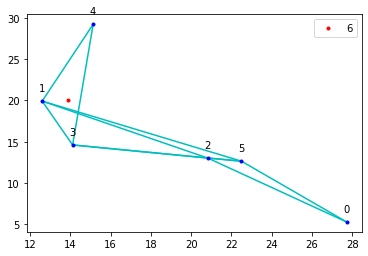

In [93]:
# 4. One node claims to be in a location it is not, and no other nodes can see it. It does not provide fake distances to its neighbors.
def make_dishonest4(C, D, minpeer=3, dishonesty=0.1):
    _C = np.copy(C)
    _D = np.copy(D)

    # Choose random node with more than minpeer peers
    # We do this because we want to place the new fake node
    # close to a number of other nodes.
    nz = np.count_nonzero(_D, axis=1)
    nz = np.where(nz >= minpeer)[0]
    i = nz[np.random.randint(0, nz.size)]
    
    # Offset node by random offsets scaled to field size and desired amount of dishonesty
    # We then append the offset node to the end of the array instead of changing an existing node
    xrand = FIELD_SIZE * np.random.normal(0, dishonesty)
    yrand = FIELD_SIZE * np.random.normal(0, dishonesty)
    _C = np.append(_C, np.array([[_C[i][0] + xrand, _C[i][1] + yrand]]), axis=0)

    # Add zeros in the distances matrix
    
    
    print("dishonest coordinates", _C[-1])
    
    plot_points(C)
    plt.plot(_C[-1][0], _C[-1][1], 'r.', label=_C.shape[0] - 1)
    plt.legend()
    plt.show()
    
    return (_C, _D, i)

dishonest4 = make_dishonest4(*honest)

plt.show()

dishonest index: 1
honest coordinates: [12.59452304 19.90920901]
dishonest coordinates: [14.07536009 22.96372107]


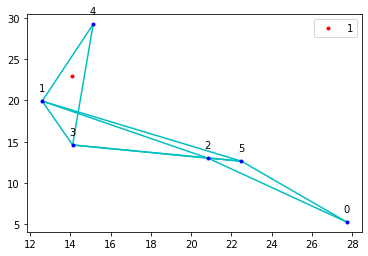

dishonest distances: [0. 0. 0. 0. 0. 0.]


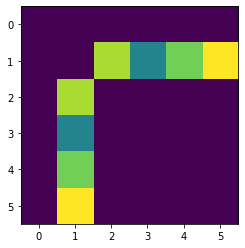

In [97]:
# 4. One node claims to be in a location it is not, and no other nodes can see it.
# It does not provide fake distances to its neighbors.
def make_dishonest4(C, D, minpeer=3, dishonesty=0.1):
    (_C, _D, i) = make_dishonest1(C, D, minpeer, dishonesty)
    
    # Erase distances for dishonest node with fake coordinates
    old = np.copy(_D)
    _D[i] = np.zeros(_D[i].shape)
    _D[0:, i] = np.zeros(_D[0:, i].shape)
    
    print("dishonest distances:", _D[i])
    
    plt.imshow(D - _D)
    plt.show()
    
    return (_C, _D, i)
    
dishonest4 = make_dishonest4(*honest)

dishonest index: 5
honest coordinates: [22.49358719 12.6201458 ]
dishonest coordinates: [16.41636262 10.71494132]


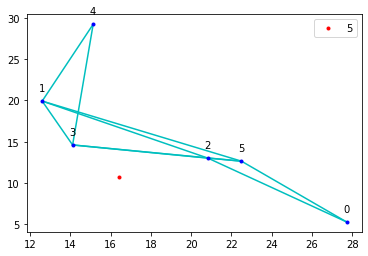

dishonest distances: [ 9.03189284 12.29316531  1.70782511  8.61489052  0.          0.        ]


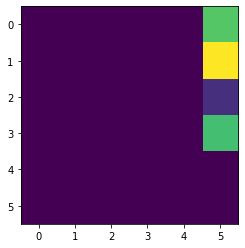

In [96]:
# 5. One node claims to be in a location it is not, and no other nodes can see it.
# It provides fake distances to it's "neighbors".
def make_dishonest5(C, D, minpeer=3, dishonesty=0.1):
    (_C, _D, i) = make_dishonest1(C, D, minpeer, dishonesty)
    
    # Erase distances for dishonest node with fake coordinates
    old = np.copy(_D)
    _D[0:, i] = np.zeros(_D[0:, i].shape)
    
    print("dishonest distances:", _D[i])
    
    plt.imshow(D - _D)
    plt.show()
    
    return (_C, _D, i)
    
dishonest5 = make_dishonest5(*honest)

dishonest index: 2
honest coordinates: [20.82660139 12.99139362]
dishonest coordinates: [21.59138586 15.72339236]


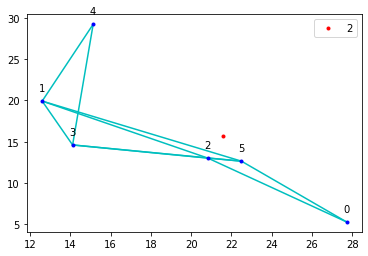

dishonest distances: [10.36204351 10.75282678  0.          6.90720299  0.          1.70782511]


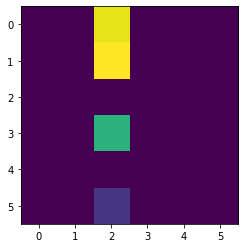

In [107]:
# A group of nodes claim to be in a location they are not, and no other nodes can see them.
# They do not provide fake distances to their "neighbors".
def make_dishonest5(C, D, minpeer=3, dishonesty=0.1):
    (_C, _D, i) = make_dishonest1(C, D, minpeer, dishonesty)
    
    # Erase distances for dishonest node with fake coordinates
    old = np.copy(_D)
    _D[0:, i] = np.zeros(_D[0:, i].shape)
    
    print("dishonest distances:", _D[i])
    
    plt.imshow(D - _D)
    plt.show()
    
    return (_C, _D, i)
    
dishonest5 = make_dishonest5(*honest)


[2 4 4 4 2 4]
[1 2 3 5]
5
[[-2.75275595  1.61403061]
 [-6.18665777 -0.31286061]
 [-4.50129104 -6.5210671 ]]
[[19.74083124 14.23417641]
 [16.30692942 12.30728519]
 [17.99229615  6.09907869]]
dishonest index: 5
honest coordinates: [22.49358719 12.6201458 ]
dishonest coordinates: [22.49358719 12.6201458 ]


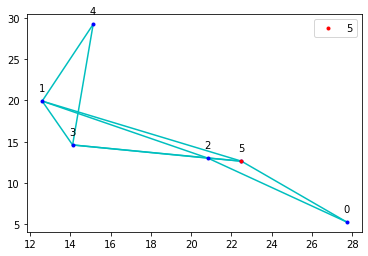

In [115]:
# 1. A group of nodes misreport its coordinates while reporting (self-contradictory) accurate distances
def make_dishonest67(C, D, minpeer=3, dishonesty=0.1, num=1):
    _C = np.copy(C)
    _D = np.copy(D)
    
    # Choose random node with more than minpeer peers
    nz = np.count_nonzero(_D, axis=1)
    print(nz)
    nz = np.where(nz >= minpeer)[0]
    print(nz)
    i = nz[np.random.randint(0, nz.size)]
    print(i)
    
    # Make new nodes with random offsets from chosen node, scaled to field size and desired amount of dishonesty
    rand = FIELD_SIZE * np.random.normal(0, dishonesty, size=[num, 2])
    print(rand)
   
    newnodes = _C[i] + rand
    print(newnodes)
    
    _C = C.append(newnodes)
    
    # Make distances matrix for all nodes
    make_dist_matrix(_C)
    
    # Delete real node's references to fake nodes
    _D = make_dist_matrix(_C)[0:C.shape[0], C.shape[0]]
    
    print("dishonest index:", i)
    print("honest coordinates:", C[i])
    print("dishonest coordinates:", _C[i])
    
    plot_points(C)
    plt.plot(_C[0:, 0], _C[i][1], 'r.', label=i)
    plt.legend()
    plt.show()
    
    return (_C, _D, i)

dishonest1 = make_dishonest67(*honest, num=3)

plt.show()
